<a href="https://colab.research.google.com/github/inf032/introducaoML/blob/master/Farmaco_Otimizacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics  import mean_squared_error
from sklearn.dummy import DummyRegressor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.impute._base import _BaseImputer

from sklearn.tree import DecisionTreeClassifier


In [2]:
class ImputerWithMissingMark (BaseEstimator, TransformerMixin):

    def transformColunas_IMPUTED(self, X) -> pd.DataFrame :
      copia = X.copy()
      for col in self.col_name_with_nan :
          copia[f'{col}{self.postfix}'] = copia[col].isna().astype(int)
      return copia      

    def col_with_nan(self, X) -> list:
      list_col_with_nan = []
      copia = X.copy()
      for col in copia.columns :
        if(copia[col].isna().sum() > 0) :
          list_col_with_nan.append(col)
      return list_col_with_nan

    def col_num_with_nan(self, X) -> list:
      cols = X.shape[1]
      list_col_with_nan = []
      for col in range(cols):    
          if(np.count_nonzero(np.isnan(X[:,col])) > 0) :  
              list_col_with_nan.append(col)
      return list_col_with_nan        

    def __init__(self, imputer=KNNImputer(), postfix = '_IMPUTED'):
      self.imputer = imputer
      self.col_name = None
      self.fitted = False
      self.col_name_with_nan = None
      self.col_number_with_nan = None
      self.postfix = postfix

    def fit_DF(self, X):
      self.col_name = X.columns.values
      self.col_name_with_nan = self.col_with_nan(X)

    def fit_NP(self, X):
      self.col_number_with_nan = self.col_num_with_nan(X)

    def transform_DF(self, X):
      copia = self.transformColunas_IMPUTED(X)
      transformed = pd.DataFrame(self.imputer.transform(copia[self.col_name]))
      transformed.columns = X.columns
      transformed.index = X.index
      for col in self.col_name_with_nan :
        transformed[f'{col}{self.postfix}'] = copia[f'{col}{self.postfix}']
      return transformed

    def transform_NP(self, X):
      transformed = np.copy(X)
      vazio = np.zeros(shape=(X.shape[0], len(self.col_number_with_nan)))
      for col in self.col_number_with_nan:
        a_nan = [1 if np.isnan(x) else 0 for x in transformed[:,col]]
        vazio = np.append(vazio, np.c_[a_nan], axis = 1)
      transformed = self.imputer.transform(transformed)  
      for col in range(vazio.shape[1]) :
        transformed = np.append(transformed, np.c_[vazio[:, col]], axis = 1)
      return transformed      

    def fit(self, X, y=None):
      if(self.fitted == False) :
        self.fitted = True
        if(type(X) == pd.DataFrame) :
          self.fit_DF(X)
        else :
          self.fit_NP(X)  
        self.imputer.fit(X)
      return self

    def transform(self, X, y=None):
      if(self.fitted == True) :
        if(self.col_name is not None) :
          transformed = self.transform_DF(X)    
        else :
          transformed = self.transform_NP(X)    
        return transformed
      else :
        return X

    def get_params(self, deep=True):
      # retorna um dicionário com os atributos e seus respectivos valores
      return {"imputer": self.imputer, 
              "postfix": self.postfix}
      
    def set_params(self, **parameters):
      # iterando pelos elementos passados e definindo-os na classe
      for parameter, value in parameters.items():
        setattr(self, parameter, value)
      return self 

In [3]:
def report_score(title, model, X_train, y_train, X_test, y_test) :
  model.fit(X_train, y_train)
  print(title, '\n')
  print(f'Acurácia treino: {np.round(model.score(X_train, y_train) *100, 2)}%')
  print(f'Acurácia teste: {np.round(model.score(X_test, y_test) *100, 2)}%')
  

In [4]:
def calcula_score(model, X_train, y_train, X_test, y_test) :
  model.fit(X_train, y_train)
  return model.score(X_train, y_train), model.score(X_test, y_test)



Leitura dos Dados


In [5]:
SEED = 48
np.random.seed(SEED)
warnings.filterwarnings(action='once')

df = pd.read_csv('https://raw.githubusercontent.com/inf032/introducaoML/master/data/farmaco.csv')
df.columns = ['IDADE', 'SEXO', 'PA', 'COLESTEROL', 'NA_K', 'FARMACO']
preditoras = ['IDADE', 'SEXO', 'PA', 'COLESTEROL', 'NA_K']
alvo = 'FARMACO'

X = df[preditoras]
y = df[alvo]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=SEED)

print(f'Holdout: {X_train.shape[0]} individuos em treino. {X_test.shape[0]} individuos em teste.')

Holdout: 168 individuos em treino. 57 individuos em teste.


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

ordinal_transformer = Pipeline(steps=[('ordinal_encoder', OrdinalEncoder(categories=[['LOW', 'NORMAL', 'HIGH'], 
                                                                                     ['LOW', 'NORMAL', 'HIGH']], 
                                                                          handle_unknown='use_encoded_value',
                                                                          unknown_value=np.nan))
                                     ])
onehot_transformer = Pipeline(steps=[('one_hot_encoder',  OneHotEncoder(drop='if_binary', sparse=False))])


col_transformer = ColumnTransformer(transformers=[('pa_colesterol', ordinal_transformer, ['PA', 'COLESTEROL']),
                                                  ('sex', onehot_transformer, ['SEXO'])],
                                    remainder='passthrough')

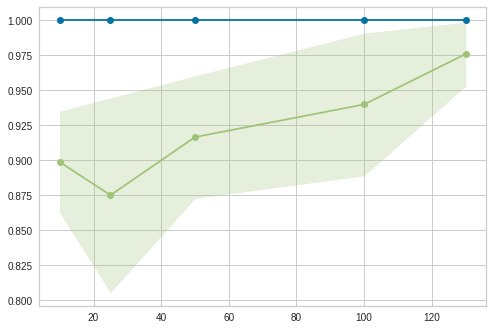

In [7]:
from yellowbrick.model_selection import LearningCurve

model = DecisionTreeClassifier()

train_sizes = [10, 25, 50, 100, 130]

vc = LearningCurve(model, cv=5, scoring='accuracy', train_sizes=train_sizes)

modelo = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()),
                         ('imputer', ImputerWithMissingMark()),
                         ('vc',  vc)]).fit(X_train, y_train)




In [8]:
print(model.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In [9]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

scores=[]


for max_depth in range(1, 30) :
  cv = KFold(n_splits = 5, shuffle=True, random_state=327)
  model = DecisionTreeClassifier(max_depth=max_depth)
  modelo = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()), 
                           ('imputer', ImputerWithMissingMark()), ('classificador', model)])
  resultado_cv = cross_validate(modelo, X_train, y_train, cv=cv, return_train_score=True)
  scores.append([max_depth, np.round(resultado_cv['train_score'].mean()*100,2), np.round(resultado_cv['test_score'].mean()*100,2)])

dfResultados = pd.DataFrame(scores, columns = ['MAX_DEPTH', 'TREINO', 'TESTE'])

dfResultados

,MAX_DEPTH,TREINO,TESTE
0,1,92.12,91.11
1,2,92.56,88.16
2,3,98.66,94.10
3,4,99.85,97.04
4,5,100.00,97.04
5,6,100.00,97.04
6,7,100.00,95.86
7,8,100.00,95.86
8,9,100.00,95.86
9,10,100.00,97.04


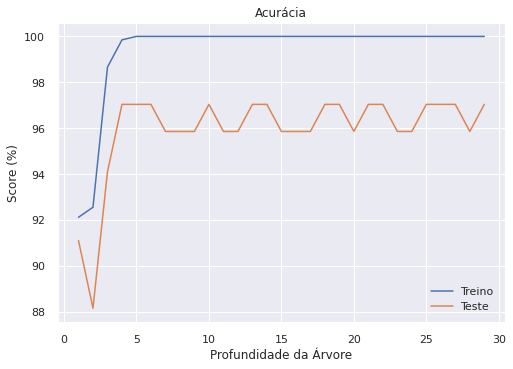

In [10]:
import seaborn as sns
sns.set_theme(style="darkgrid")


ax = sns.lineplot(x = "MAX_DEPTH", y = "TREINO",  markers=True, data = dfResultados)
sns.lineplot(x = "MAX_DEPTH", y = "TESTE",  markers=True, data = dfResultados, ax=ax)

ax.set_title('Acurácia')
ax.set_ylabel('Score (%)')
ax.set_xlabel('Profundidade da Árvore')

plt.legend(["Treino", "Teste"])



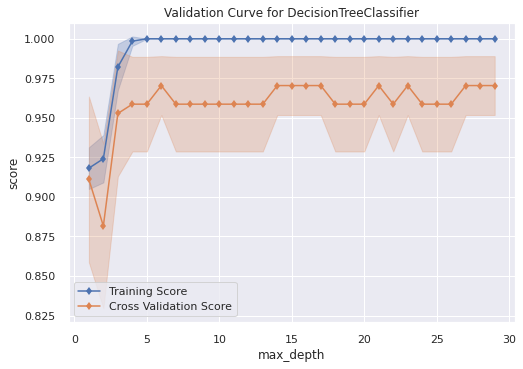

In [11]:
from yellowbrick.model_selection import ValidationCurve

cv = KFold(n_splits = 5, shuffle=True, random_state=327)

vc = ValidationCurve(DecisionTreeClassifier(), param_name='max_depth', 
                     param_range=np.arange(1, 30), cv=cv)


modelo = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()), 
                          ('imputer', ImputerWithMissingMark()), ('classificador', vc)])

modelo.fit(X_train, y_train)
vc.show()

In [12]:
scores=[]
for max_depth in range(1, 30) :
  for min_samples_leaf in range(1, 10) :
    cv = KFold(n_splits = 5, shuffle=True, random_state=327)
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    modelo = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()), 
                             ('imputer', ImputerWithMissingMark()), ('classificador', model)])
  
    resultado_cv = cross_validate(modelo, X_train, y_train, cv=cv, return_train_score=True)
    scores.append([max_depth, min_samples_leaf, np.round(resultado_cv['train_score'].mean()*100,2), np.round(resultado_cv['test_score'].mean()*100,2), np.round(resultado_cv['score_time'].mean()*100,2)])

dfResultados = pd.DataFrame(scores, columns = ['MAX_DEPTH', 'MIN_SAMPLES_LEAF', 'TREINO', 'TESTE', 'TEMPO'])

dfResultados.sort_values(['TESTE', 'TEMPO'], ascending=[False, True])

,MAX_DEPTH,MIN_SAMPLES_LEAF,TREINO,TESTE,TEMPO
217,25,2,99.11,97.04,0.59
172,20,2,99.11,97.04,0.60
182,21,3,99.11,97.04,0.60
144,17,1,100.00,97.04,0.61
216,25,1,100.00,97.04,0.61
...,...,...,...,...,...
9,2,1,92.56,88.16,1.26
13,2,5,92.56,88.16,1.30
15,2,7,92.27,88.16,1.56
16,2,8,92.27,88.16,1.58


In [13]:
corr = dfResultados[['MAX_DEPTH',	'MIN_SAMPLES_LEAF', 'TESTE', 'TREINO']].corr()
corr

,MAX_DEPTH,MIN_SAMPLES_LEAF,TESTE,TREINO
MAX_DEPTH,1.000000e+00,8.443473e-17,0.382704,0.428643
MIN_SAMPLES_LEAF,8.443473e-17,1.000000e+00,-0.365615,-0.304234
TESTE,3.827043e-01,-3.656152e-01,1.000000,0.875268
TREINO,4.286428e-01,-3.042338e-01,0.875268,1.000000


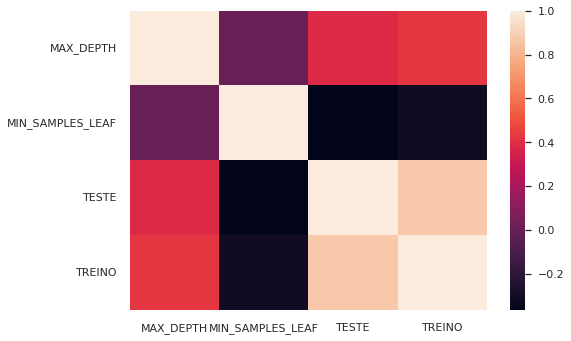

In [14]:
sns.heatmap(corr)

In [15]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

scores=[]


for n_neighbors in range(1, 20) :
  cv = KFold(n_splits = 5, shuffle=True, random_state=327)
  model = KNeighborsClassifier(n_neighbors = n_neighbors)
  modelo = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()), 
                           ('imputer', ImputerWithMissingMark()), ('classificador', model)])
  resultado_cv = cross_validate(modelo, X_train, y_train, cv=cv, return_train_score=True)
  scores.append([n_neighbors, np.round(resultado_cv['train_score'].mean()*100,2), np.round(resultado_cv['test_score'].mean()*100,2)])

dfResultados = pd.DataFrame(scores, columns = ['N_NEIGHBORS', 'TREINO', 'TESTE'])

dfResultados

,N_NEIGHBORS,TREINO,TESTE
0,1,100.00,86.90
1,2,95.68,86.31
2,3,93.75,82.78
3,4,91.66,77.45
4,5,89.43,82.80
5,6,87.65,78.66
6,7,86.61,80.39
7,8,86.46,82.21
8,9,86.61,81.05
9,10,87.35,82.21


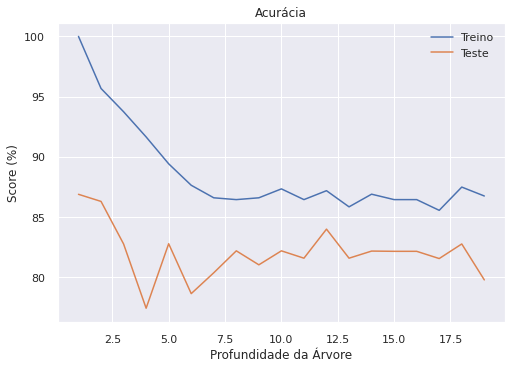

In [16]:
import seaborn as sns
sns.set_theme(style="darkgrid")


ax = sns.lineplot(x = "N_NEIGHBORS", y = "TREINO",  markers=True, data = dfResultados)
sns.lineplot(x = "N_NEIGHBORS", y = "TESTE",  markers=True, data = dfResultados, ax=ax)

ax.set_title('Acurácia')
ax.set_ylabel('Score (%)')
ax.set_xlabel('Profundidade da Árvore')

plt.legend(["Treino", "Teste"])

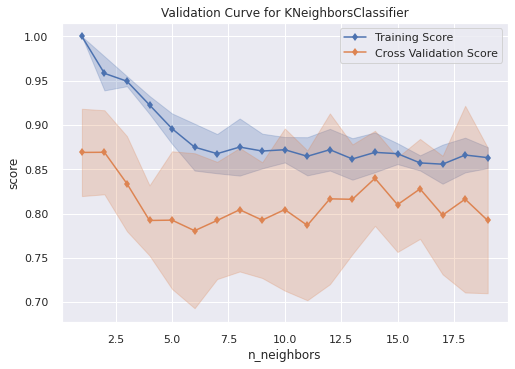

In [17]:
from yellowbrick.model_selection import ValidationCurve

cv = KFold(n_splits = 5, shuffle=True, random_state=327)

vc = ValidationCurve(KNeighborsClassifier(), param_name='n_neighbors', 
                     param_range=np.arange(1, 20), cv=cv)


modelo = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()), 
                           ('imputer', ImputerWithMissingMark()), ('classificador', vc)])

modelo.fit(X_train, y_train)
vc.show()

In [18]:
scores=[]
for n_neighbors in range(1, 20) :
  for weights in ['uniform','distance'] :
    cv = KFold(n_splits = 5, shuffle=True, random_state=327)
    model = KNeighborsClassifier(n_neighbors = n_neighbors, weights=weights)
    modelo = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()), 
                             ('imputer', ImputerWithMissingMark()), ('classificador', model)])
  
    resultado_cv = cross_validate(modelo, X_train, y_train, cv=cv, return_train_score=True)
    scores.append([n_neighbors, weights, np.round(resultado_cv['train_score'].mean()*100,2), np.round(resultado_cv['test_score'].mean()*100,2), np.round(resultado_cv['score_time'].mean()*100,2)])

dfResultados = pd.DataFrame(scores, columns = ['N_NEIGHBORS', 'WEIGHTS', 'TREINO', 'TESTE', 'TEMPO'])

dfResultados.sort_values(['TESTE', 'TEMPO'], ascending=[False, True])

,N_NEIGHBORS,WEIGHTS,TREINO,TESTE,TEMPO
25,13,distance,100.00,88.15,2.53
29,15,distance,100.00,86.95,0.76
37,19,distance,100.00,86.95,1.27
19,10,distance,100.00,86.93,0.77
35,18,distance,100.00,86.93,1.74
3,2,distance,100.00,86.90,0.89
1,1,distance,100.00,86.90,2.13
0,1,uniform,100.00,86.90,2.55
33,17,distance,100.00,86.36,1.30
2,2,uniform,95.68,86.31,1.26


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f06a2c63850>,
      dtype=object)

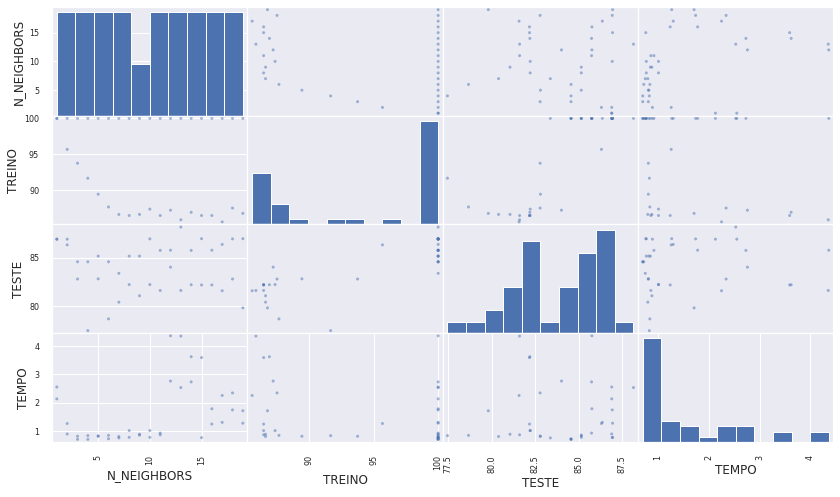

In [19]:
pd.plotting.scatter_matrix(dfResultados, figsize = (14, 8))

In [20]:
scores=[]
for max_depth in range(1, 30) :
  for min_samples_leaf in range(1, 10) :
    for min_samples_split in [2, 5, 10] :
      cv = KFold(n_splits = 5, shuffle=True, random_state=327)
      model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
      modelo = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()), 
                               ('imputer', ImputerWithMissingMark()), ('classificador', model)])

      resultado_cv = cross_validate(modelo, X_train, y_train, cv=cv, return_train_score=True)
      scores.append([max_depth, min_samples_leaf, min_samples_split, np.round(resultado_cv['train_score'].mean()*100,2), np.round(resultado_cv['test_score'].mean()*100,2), np.round(resultado_cv['score_time'].mean()*100,2)])

dfResultados = pd.DataFrame(scores, columns = ['MAX_DEPTH', 'MIN_SAMPLES_LEAF', 'MIN_SAMPLES_SPLIT' ,'TREINO', 'TESTE', 'TEMPO'])

dfResultados.sort_values(['TESTE', 'TEMPO'], ascending=[False, True])

,MAX_DEPTH,MIN_SAMPLES_LEAF,MIN_SAMPLES_SPLIT,TREINO,TESTE,TEMPO
573,22,3,2,99.11,97.04,0.60
433,17,1,5,99.41,97.04,0.61
519,20,3,2,99.11,97.04,0.61
571,22,2,5,99.11,97.04,0.61
594,23,1,2,100.00,97.04,0.61
...,...,...,...,...,...,...
40,2,5,5,92.56,88.16,1.32
32,2,2,10,92.56,88.16,1.35
43,2,6,5,92.56,88.16,1.40
31,2,2,5,92.56,88.16,1.45


In [21]:
from sklearn.model_selection import GridSearchCV

espaco_de_parametros = {
    'classificador__max_depth' : [2, 10, 30],
    'classificador__min_samples_split': [2, 3, 6, 9],
    'classificador__min_samples_leaf': [2, 5, 10],
    'classificador__criterion': ["gini", "entropy"]
}

cv = KFold(n_splits = 5, shuffle=True, random_state=327)


modelo = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()), 
                         ('imputer', ImputerWithMissingMark()), ('classificador', DecisionTreeClassifier())])

search = GridSearchCV(modelo, espaco_de_parametros, cv = cv)

search.fit(X_train, y_train)
resultados = pd.DataFrame(search.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classificador__criterion,param_classificador__max_depth,param_classificador__min_samples_leaf,param_classificador__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011625,0.001062,0.006433,0.000754,gini,2,2,2,"{'classificador__criterion': 'gini', 'classifi...",0.852941,0.823529,0.852941,0.969697,0.909091,0.88164,0.052022,49
1,0.010863,0.000461,0.006363,0.000692,gini,2,2,3,"{'classificador__criterion': 'gini', 'classifi...",0.852941,0.823529,0.852941,0.969697,0.909091,0.88164,0.052022,49
2,0.013173,0.004683,0.006304,0.000321,gini,2,2,6,"{'classificador__criterion': 'gini', 'classifi...",0.852941,0.823529,0.852941,0.969697,0.909091,0.88164,0.052022,49
3,0.010663,0.000526,0.006048,0.000617,gini,2,2,9,"{'classificador__criterion': 'gini', 'classifi...",0.852941,0.823529,0.852941,0.969697,0.909091,0.88164,0.052022,49
4,0.011018,0.001077,0.006519,0.000527,gini,2,5,2,"{'classificador__criterion': 'gini', 'classifi...",0.852941,0.823529,0.852941,0.969697,0.909091,0.88164,0.052022,49


In [22]:
print(search.best_params_)
print(search.best_score_ * 100)

{'classificador__criterion': 'gini', 'classificador__max_depth': 10, 'classificador__min_samples_leaf': 2, 'classificador__min_samples_split': 3}
97.0409982174688


In [23]:
from sklearn.model_selection import GridSearchCV

espaco_de_parametros = {
    'classificador__n_neighbors' : np.arange(1,16),
    'classificador__leaf_size': np.arange(20,40),
    'classificador__weights': ['uniform', 'distance'],
    'classificador__metric': ['minkowski', 'chebyshev']
}

cv = KFold(n_splits = 5, shuffle=True, random_state=327)


modelo = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()), 
                         ('imputer', ImputerWithMissingMark()), ('classificador', KNeighborsClassifier())])

search = GridSearchCV(modelo, espaco_de_parametros, cv = cv)

search.fit(X_train, y_train)
resultados = pd.DataFrame(search.cv_results_)
resultados.head()



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classificador__leaf_size,param_classificador__metric,param_classificador__n_neighbors,param_classificador__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011414,0.000944,0.007941,0.000748,20,minkowski,1,uniform,"{'classificador__leaf_size': 20, 'classificado...",0.852941,0.852941,0.911765,0.787879,0.939394,0.868984,0.052689,61
1,0.010866,0.000790,0.007247,0.000673,20,minkowski,1,distance,"{'classificador__leaf_size': 20, 'classificado...",0.852941,0.852941,0.911765,0.787879,0.939394,0.868984,0.052689,61
2,0.010763,0.001099,0.007829,0.000394,20,minkowski,2,uniform,"{'classificador__leaf_size': 20, 'classificado...",0.941176,0.852941,0.794118,0.848485,0.878788,0.863102,0.047786,127
3,0.012102,0.001738,0.007358,0.001067,20,minkowski,2,distance,"{'classificador__leaf_size': 20, 'classificado...",0.852941,0.852941,0.911765,0.787879,0.939394,0.868984,0.052689,61
4,0.011243,0.000959,0.008252,0.000749,20,minkowski,3,uniform,"{'classificador__leaf_size': 20, 'classificado...",0.735294,0.852941,0.823529,0.848485,0.878788,0.827807,0.049468,481


In [24]:
print(search.best_params_)
print(search.best_score_ * 100)

{'classificador__leaf_size': 20, 'classificador__metric': 'minkowski', 'classificador__n_neighbors': 13, 'classificador__weights': 'distance'}
88.14616755793226


In [25]:
from sklearn.model_selection import cross_val_score

#scores = cross_val_score(search, X_train, y_train, cv=cv)



In [ ]:
#scores.mean()

0.8279857397504455

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

espaco_de_parametros = {
    'classificador__max_depth' : randint(2,35),
    'classificador__min_samples_split': randint(2,15),
    'classificador__min_samples_leaf': randint(2,15),
    'classificador__criterion': ["gini", "entropy"]
}

cv = KFold(n_splits = 5, shuffle=True, random_state=327)


modelo = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()), 
                         ('imputer', ImputerWithMissingMark()), ('classificador', DecisionTreeClassifier())])

search = RandomizedSearchCV(modelo, espaco_de_parametros, 
                            n_iter = 30,
                            cv = cv,
                            random_state = SEED)

search.fit(X_train, y_train)
resultados = pd.DataFrame(search.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classificador__criterion,param_classificador__max_depth,param_classificador__min_samples_leaf,param_classificador__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.026513,0.012777,0.016965,0.011507,gini,19,6,13,"{'classificador__criterion': 'gini', 'classifi...",0.941176,0.970588,0.941176,0.969697,1.000000,0.964528,0.021965,7
1,0.011568,0.000643,0.006894,0.001080,gini,2,8,8,"{'classificador__criterion': 'gini', 'classifi...",0.852941,0.823529,0.852941,0.969697,0.909091,0.881640,0.052022,23
2,0.011502,0.000737,0.006537,0.000423,gini,30,2,14,"{'classificador__criterion': 'gini', 'classifi...",0.941176,0.970588,0.941176,0.969697,1.000000,0.964528,0.021965,7
3,0.011199,0.001006,0.006429,0.000747,entropy,8,8,2,"{'classificador__criterion': 'entropy', 'class...",0.941176,0.970588,0.852941,0.969697,1.000000,0.946881,0.050520,12
4,0.014141,0.003778,0.007314,0.001048,entropy,30,9,12,"{'classificador__criterion': 'entropy', 'class...",0.941176,0.970588,0.852941,0.969697,1.000000,0.946881,0.050520,12


In [27]:
print(search.best_params_)
print(search.best_score_ * 100)

{'classificador__criterion': 'entropy', 'classificador__max_depth': 30, 'classificador__min_samples_leaf': 4, 'classificador__min_samples_split': 8}
97.0409982174688


{'classificador__criterion': 'gini', 'classificador__max_depth': 10, 'classificador__min_samples_leaf': 2, 'classificador__min_samples_split': 3}: 97.0409982174688 </p>
{'classificador__criterion': 'entropy', 'classificador__max_depth': 30, 'classificador__min_samples_leaf': 4, 'classificador__min_samples_split': 8}
97.0409982174688
 


In [28]:
espaco_de_parametros = {
    'classificador__n_neighbors' : randint(1,20),
    'classificador__leaf_size': randint(15,45),
    'classificador__weights': ['uniform', 'distance'],
    'classificador__metric': ['minkowski', 'chebyshev']
}

cv = KFold(n_splits = 5, shuffle=True, random_state=327)


modelo = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()), 
                         ('imputer', ImputerWithMissingMark()), ('classificador', KNeighborsClassifier())])

search = RandomizedSearchCV(modelo, espaco_de_parametros, 
                            n_iter = 30,
                            cv = cv,
                            random_state = SEED)

search.fit(X_train, y_train)
resultados = pd.DataFrame(search.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classificador__leaf_size,param_classificador__metric,param_classificador__n_neighbors,param_classificador__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012458,0.000759,0.008939,0.001108,15,chebyshev,18,uniform,"{'classificador__leaf_size': 15, 'classificado...",0.647059,0.647059,0.735294,0.757576,0.787879,0.714973,0.057910,28
1,0.012816,0.002164,0.008551,0.000713,42,minkowski,1,uniform,"{'classificador__leaf_size': 42, 'classificado...",0.852941,0.852941,0.911765,0.787879,0.939394,0.868984,0.052689,4
2,0.011562,0.000950,0.009150,0.002023,21,minkowski,17,uniform,"{'classificador__leaf_size': 21, 'classificado...",0.764706,0.794118,0.852941,0.848485,0.818182,0.815686,0.033269,19
3,0.011220,0.000904,0.008631,0.001812,44,minkowski,15,uniform,"{'classificador__leaf_size': 44, 'classificado...",0.764706,0.794118,0.852941,0.878788,0.818182,0.821747,0.040636,17
4,0.011124,0.000899,0.008796,0.000403,42,minkowski,8,uniform,"{'classificador__leaf_size': 42, 'classificado...",0.794118,0.705882,0.852941,0.939394,0.818182,0.822103,0.076176,16


In [29]:
print(search.best_params_)
print(search.best_score_ * 100)

{'classificador__leaf_size': 37, 'classificador__metric': 'minkowski', 'classificador__n_neighbors': 13, 'classificador__weights': 'distance'}
88.14616755793226
